In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Top 15 variables más importantes
LONGITUD_NUM                  0.233396
LATITUD_NUM                   0.216568
MTS2VENTAS_NUM                0.155598
PUERTASREFRIG_NUM             0.067534
PLAZA_CVE                     0.050377
CAJONESESTACIONAMIENTO_NUM    0.046718
NIVELSOCIOECONOMICO_DES       0.028270
UBICACION_UT_GAS_URBANA       0.028115
SEGMENTO_Parada Técnica       0.021965
SEGMENTO_Hogar Reunión        0.020803
ENTORNO_Base                  0.020744
ENTORNO_Receso                0.018005
ENTORNO_Hogar                 0.016529
UBICACION_UT_DENSIDAD         0.014213
SEGMENTO_Missing              0.013983
dtype: float64


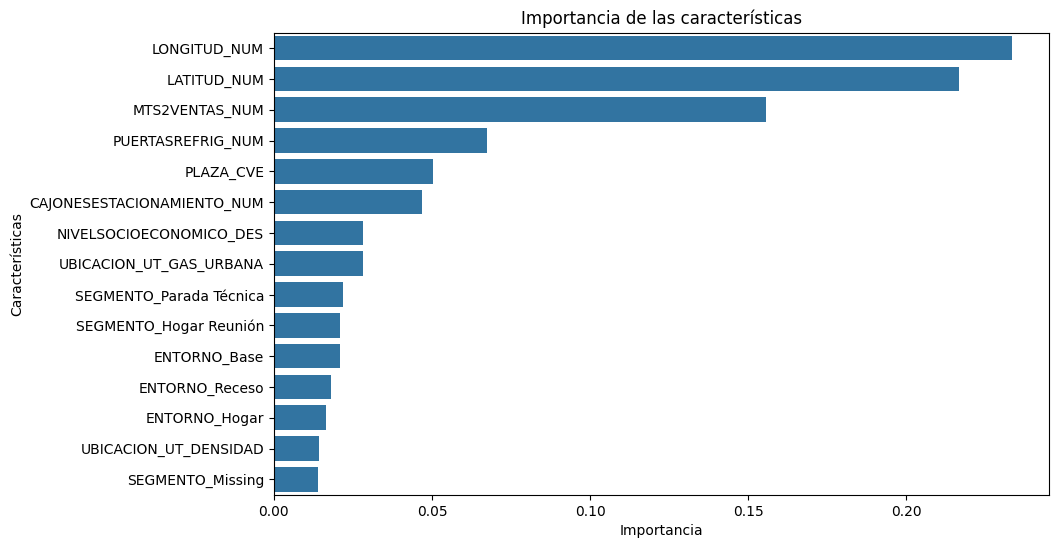

In [8]:
# Vamos a cargar el dataset de Reto Oxxo Datathon 2025
df = pd.read_csv("/home/cesar/Descargas/Dataset_Train_limpio.csv")

# Ahora, necesitamos separar características X y etiquetas y
X = df.drop(columns=["EXITOSA"])
y = df["EXITOSA"]

# Ahora queremos dividir entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    stratify=y,       # Para mantener la proporción entre clases
    random_state=2025
)

# Ahora, queremos crear y entrenar el Random Forest
random_forest = RandomForestClassifier(
    n_estimators=100,      # Número de árboles
    max_depth=None,        # Profundidad máxima de los árboles
    min_samples_split=2,   # Mínimo de muestras para dividir un nodo
    min_samples_leaf=1,    # Mínimo de muestras en una hoja
    n_jobs=1,              # Número de trabajos paralelos
    random_state=2025     
)

random_forest.fit(X_train, y_train)   # Entrenamos el modelo


# Ahora, queremos ver la importancia de las características
importances = random_forest.feature_importances_
feat_imp = pd.Series(importances, index=X.columns)


# Podemos ordenar de mayor a menor
feat_imp = feat_imp.sort_values(ascending=False)

# Ya con ello, podemo smostrar las 10 variables más importanes (o las que queramos)
print("Top 15 variables más importantes")
print(feat_imp.head(15))

# Finalmente, podemos graficar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title("Importancia de las características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()





Lo que vemos en el gráfico son las Gini Importances acorde a un modelo de Random Forest, i.e. la fracción de reducción de impureza aportada por cada variable al construir los árboles. Este análisis nos puede indicar algunas cosas interesantes:

| Variable                        | Importancia | Grupo                | Comentario clave                                                                                           |
| ------------------------------- | ----------: | -------------------- | ---------------------------------------------------------------------------------------------------------- |
| **LONGITUD\_NUM**               |      0.2334 | Geografía            | Posición este–oeste: junto con latitud explican casi la mitad de la impureza.                              |
| **LATITUD\_NUM**                |      0.2166 | Geografía            | Posición norte–sur. Crucial para capturar zonas de alta o baja afluencia.                                  |
| **MTS2VENTAS\_NUM**             |      0.1556 | Tamaño               | Área de ventas en m². Tiendas más grandes tienen más probabilidad de éxito.                                |
| **PUERTASREFRIG\_NUM**          |      0.0675 | Infraestructura      | Número de puertas de refrigeración: capacidad operativa y oferta de producto.                              |
| **PLAZA\_CVE**                  |      0.0504 | Ubicación categórica | Código de plaza o centro comercial; variables categóricas de alta cardinalidad suelen “robar” importancia. |
| **CAJONESESTACIONAMIENTO\_NUM** |      0.0467 | Infraestructura      | Espacios de estacionamiento: facilita el acceso y aumenta afluencia.                                       |
| **NIVELSOCIOECONOMICO\_DES**    |      0.0283 | Demográfico          | Nivel socioeconómico del área. Refleja poder adquisitivo de la clientela.                                  |
| **UBICACION\_UT\_GAS\_URBANA**  |      0.0281 | Entorno urbano       | Proximidad a gasolinera en zona urbana: atrae clientes en ruta.                                            |
| **SEGMENTO\_Parada Técnica**    |      0.0220 | Segmento de mercado  | “Parada Técnica” indica un patrón de compra específico.                                                    |
| **SEGMENTO\_Hogar Reunión**     |      0.0208 | Segmento de mercado  | Patrones de compra en reuniones familiares.                                                                |
| **ENTORNO\_Base**               |      0.0207 | Tipo de entorno      | “Base” (plantón urbano): indica tráfico peatonal y mix comercial.                                          |
| **ENTORNO\_Receso**             |      0.0180 | Tipo de entorno      | Zonas de descanso o recreo: menor flujo continuo, impacto moderado.                                        |
| **ENTORNO\_Hogar**              |      0.0165 | Tipo de entorno      | Entorno residencial: flujo dirigido a residentes, menos transitorio.                                       |
| **UBICACION\_UT\_DENSIDAD**     |      0.0142 | Entorno urbano       | Densidad de tráfico peatonal/vehicular: mide concentración de gente.                                       |
| **SEGMENTO\_Missing**           |      0.0140 | Segmento de mercado  | Valor faltante en segmento: puede indicar tiendas con información incompleta.                              |


En Random Forest, la impureza es una medida de cuán mezcladas están las clases en un nodo dado. Cuanto más puro es un nodo, más homogéneas son sus observaciones. Cuando encontramos que LONGITUD_NUM y LATITUD_NUM juntas explican “casi la mitad de la impureza”, nos referimos a que:

\begin{equation*}
    \text{Importancia}(\text{Longitud}) + \text{Importancia}(\text{Latitud}) \approx 0.2334 + 0.2166 = 0.45
\end{equation*}

Esto significa que el 45% de toda lar educción de impureza del modelo se debe a particiones basadas en la longitud y latitud. Es decir, casi la mitad de las mejoras en la pureza de los ndoos, o la capacidad del bosque para seprar tiendas esxitosas de no exitosas, provienen de información geográfica, acorde al modelo de Random Forest. 

# Permutation Importance

Con permutation importance podemos cuantificar, para cada una de nuestras variables, cuánto se aporta de verdad al desempeño del modelo. Así, en lugar de basarnos solo en la reducción de impureza interna, que puede inflar la improtancia de variables fuertemente correlacionadas, medimos el impacto en la métrica, como sería `accuracy`, `AUC` o `F1-score`, cuando rompemos aleatoriamente la relación de dichas variables con la variable objetivo. 

### Intuición detrás del modelo

Sea:

* $f: R^d \rightarrow Y$ el modelo entrenado.

* $L(f(X), Y)$ la función de pérdida (p.e. MSE, log-loss, 1-accuracy)

* $R(f) = E_{(X, Y)} \big[L(f(X), Y)\big]$ el riesgo o error esperado sobre la distribución conjunta de $(X, Y)$. 

#### Para cuantificar la contribución de la variable $X_j$:

Definimos "Riesgo Permutado", una versión alterada de los datos:

\begin{equation*}
    X^{(j)} = \big(X_1,..., X_{j-1}, X'_j, X_{j+1},..., X_d\big)    
\end{equation*}

Donde $X'_j$ es una permutación aleatoria de la componente $X_j$, tal que $X_j' \bot (X_j, Y)$, pero conserva la misma distribución marginal. 

#### Ahora, definimos la improtancia como aumento de riesgo:

\begin{equation*}
        R^{(j)}(f) = E_{(X,Y)} \big[L(f(X^{j}), Y)\big]
\end{equation*}

y definimos también la importnacia de $X_j$ como:

\begin{equation*}
    \Delta_j = R^{(j)} (f) - R(f) \geq 0
\end{equation*}

* Si $\Delta_j \approx 0$, entonces permutar $X_j$ no degrada el desempeño, por lo que $X_j$ es irrelevante.

* Si $\Delta_j >> 0$, la ausencia de información de $X_j$ perjudica el modelo, enotnces $X_j$ es importante. 


#### Ahora, la estimación muestral. En un conjunto de validación con $n$ observaciones:

\begin{equation*}
    \Delta_j = \sum_{i=1}^{n} \left( L(f(x_i^{(j)}), y_i) - L(f(x_i), y_i) \right)
\end{equation*}

Donde $x_i^{(j)}$ es $x_i$ con su j-ésima componente permutada. Al permutar $X_j$ también se destruyen sus posibles interacciones con otras variabkes, de modo que $\Delta_j$ incorpora tanto el efecto principal como los efectos de interacción entre $X_j$ y $X_{-j}$.

#### Así, la PFI cuantifica la sensibilidad del riesgo esperado del modelo a la "aniquilación" de cada variable:

\begin{equation*}
    \Delta_j = E \big[L(f(X^{(j)}), Y)\big] - E \big[L(f(X), Y)\big]
\end{equation*}

Es decir, la primera parte de la diferencia es el riesgo sin $X_j$, mientras que la segunda parte de la diferncia es el riesgo original. Un $\Delta_j$ grande implica que $X_j$ aporta información predictiva sustancial, mientras que uno cercano a cero, indica que el modelo puede desechar esa variable sin perder precisión. 


### Cómo funciona?

Para cada varibale $X_j$:

* Sonbre un conjunto de valdiación, o test bien separado, permuta aleatoriamente los valores $X_j$, dejando intactas todas las demás variables. 

* Evalúa el modelo sobre el dataset permutado, y así calcula la nueva métrica (p.e. `accuracy`).

* La diferencia entre la métrica original y la métrica tras permutar $X_j$ es la importancia de $X_j$. Es decir, cuanto mayor la caída en el score, más importante era dicha variable. 

* Este proceso se puede repetir varias veces, para así estabilizar la estimación y obtener una desviación estándar. 

Esto puede darnos un análisis más robusto porque cuenta con interacción y colinealidades de forma natural. Si dos variables están fuertemente correlacionadas, el hecho de permutar no degradará el demsempeño, y viceversa. Además, funciona en cualquier estimador que tenga un método `predict` o `predict_proba`. 

In [15]:
perm = permutation_importance(
    estimator=random_forest,
    X=X_test, y=y_test,
    scoring="roc_auc",
    n_repeats=20, random_state=2025, n_jobs=-1
)
print(pd.Series(perm.importances_mean, index=X_test.columns)
        .sort_values(ascending=False).head(15))

CAJONESESTACIONAMIENTO_NUM    0.075545
SEGMENTO_Oficinistas          0.042377
PUERTASREFRIG_NUM             0.038731
ENTORNO_Base                  0.037879
ENTORNO_Hogar                 0.033594
SEGMENTO_Parada Técnica       0.028693
NIVELSOCIOECONOMICO_DES       0.023224
LONGITUD_NUM                  0.014938
LATITUD_NUM                   0.008475
UBICACION_UT_CARRETERA_GAS    0.007008
SEGMENTO_Clásico              0.000047
ENTORNO_Peatonal              0.000000
SEGMENTO_Missing              0.000000
UBICACION_UT_GAS_URBANA      -0.002675
SEGMENTO_Hogar Reunión       -0.003883
dtype: float64


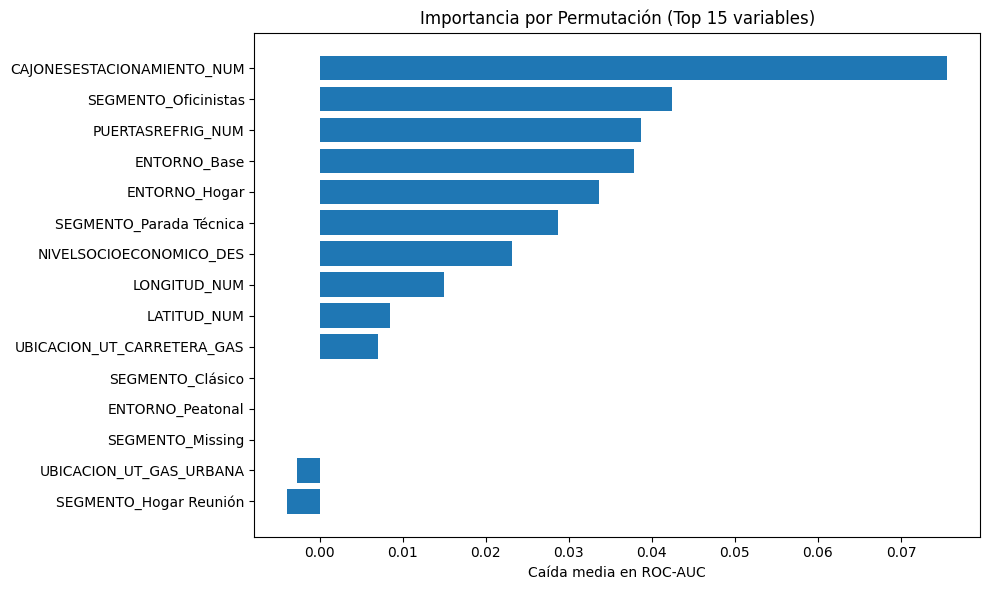

In [20]:
# 2) Convierte a Series y selecciona top 15
imp_mean = pd.Series(perm.importances_mean, index=X_test.columns)
top15 = imp_mean.sort_values(ascending=False).head(15)

# 3) Grafica barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top15.index, top15.values)
plt.xlabel("Caída media en ROC-AUC")
plt.title("Importancia por Permutación (Top 15 variables)")
plt.gca().invert_yaxis()  # muestra la más importante arriba
plt.tight_layout()
plt.show()

En permutaciones, un valor positivo grande significa que permutar esa variable empeora la métrica, luego la variable es importante. Sin embargo, un valor cercano a cero significa que permutar no cambia la métrica, por lo que la variable es irrelevante. Un valor ligeramnete negativo significa que permutar la variable mejora la mérica, señalando que dicha varaibale no apaorta o incluso confunde al modelo. 


| Variable                        | Caída media en ROC-AUC | Interpretación                                                              |
| ------------------------------- | ---------------------: | --------------------------------------------------------------------------- |
| **CAJONESESTACIONAMIENTO\_NUM** |                 0.0755 | El espacio de estacionamiento es clave: quitarlo penaliza mucho el AUC.     |
| **SEGMENTO\_Oficinistas**       |                 0.0424 | El perfil “Oficinistas” explica patrones de compra muy distintos.           |
| **PUERTASREFRIG\_NUM**          |                 0.0387 | La capacidad de refrigeración es relevante para la predicción.              |
| **ENTORNO\_Base**               |                 0.0379 | Las tiendas en entorno “Base” (plantón urbano) tienen un patrón distintivo. |
| **ENTORNO\_Hogar**              |                 0.0336 | Entornos residenciales afectan la demanda de forma consistente.             |

Después de las permutaciones, Longitud y Latitud pierden mucha fuerza, cayendo hasta el puesto 8 y 9. Aunque en la importancia Gini Dominaban, en términos de AUC su aprote es bastante menor de lo pensado, una vez que se controla por desbalnace y se usa una métrica más robusta. 

| Variable                   | Caída media | Nota                                                                    |
| -------------------------- | ----------: | ----------------------------------------------------------------------- |
| SEGMENTO\_Clásico          |     0.00005 | Prácticamente irrelevante                                               |
| ENTORNO\_Peatonal          |     0.00000 | No aporta nada a la métrica                                             |
| SEGMENTO\_Missing          |     0.00000 | Ausencia de segmento no informa al modelo                               |
| UBICACION\_UT\_GAS\_URBANA |    –0.00268 | Su permutación mejora ligeramente el AUC → ruido o colinealidad inversa |
| SEGMENTO\_Hogar Reunión    |    –0.00388 | Idem anterior                                                           |




In [25]:
perm = permutation_importance(
    estimator=random_forest,
    X=X_test, y=y_test,
    scoring="average_precision",
    n_repeats=20, random_state=2025, n_jobs=-1
)
print(pd.Series(perm.importances_mean, index=X_test.columns)
        .sort_values(ascending=False).head(15))

CAJONESESTACIONAMIENTO_NUM    0.005465
SEGMENTO_Oficinistas          0.005168
SEGMENTO_Parada Técnica       0.004442
PUERTASREFRIG_NUM             0.003845
ENTORNO_Hogar                 0.002286
ENTORNO_Base                  0.002278
NIVELSOCIOECONOMICO_DES       0.001917
LONGITUD_NUM                  0.001498
LATITUD_NUM                   0.000889
UBICACION_UT_CARRETERA_GAS    0.000569
SEGMENTO_Clásico              0.000016
ENTORNO_Peatonal              0.000000
SEGMENTO_Missing              0.000000
SEGMENTO_Hogar Reunión       -0.000025
UBICACION_UT_GAS_URBANA      -0.000309
dtype: float64


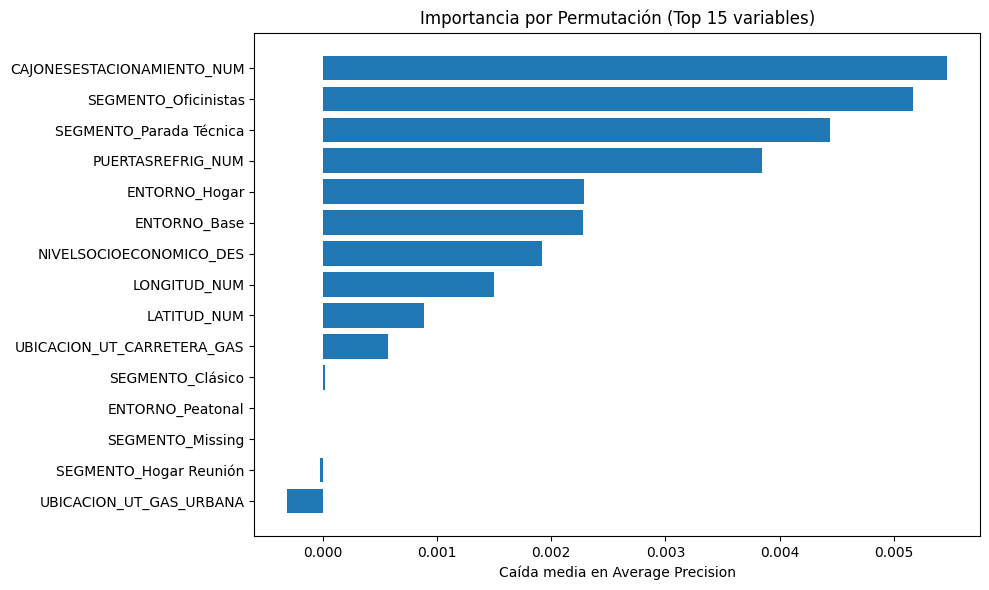

In [26]:
# 2) Convierte a Series y selecciona top 15
imp_mean = pd.Series(perm.importances_mean, index=X_test.columns)
top15 = imp_mean.sort_values(ascending=False).head(15)

# 3) Grafica barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top15.index, top15.values)
plt.xlabel("Caída media en Average Precision")
plt.title("Importancia por Permutación (Top 15 variables)")
plt.gca().invert_yaxis()  # muestra la más importante arriba
plt.tight_layout()
plt.show()

| Variable                      | Avg. Precision | Rank AP |   ROC AUC | Rank ROC | ΔRank (AP−ROC) |
| ----------------------------- | -------------: | ------: | --------: | -------: | -------------: |
| CAJONESESTACIONAMIENTO\_NUM   |       0.005465 |       1 |  0.075545 |        1 |              0 |
| SEGMENTO\_Oficinistas         |       0.005168 |       2 |  0.042377 |        2 |              0 |
| SEGMENTO\_Parada Técnica      |       0.004442 |       3 |  0.028693 |        6 |             −3 |
| PUERTASREFRIG\_NUM            |       0.003845 |       4 |  0.038731 |        3 |             +1 |
| ENTORNO\_Hogar                |       0.002286 |       5 |  0.033594 |        5 |              0 |
| ENTORNO\_Base                 |       0.002278 |       6 |  0.037879 |        4 |             +2 |
| NIVELSOCIOECONOMICO\_DES      |       0.001917 |       7 |  0.023224 |        7 |              0 |
| LONGITUD\_NUM                 |       0.001498 |       8 |  0.014938 |        8 |              0 |
| LATITUD\_NUM                  |       0.000889 |       9 |  0.008475 |        9 |              0 |
| UBICACION\_UT\_CARRETERA\_GAS |       0.000569 |      10 |  0.007008 |       10 |              0 |
| SEGMENTO\_Clásico             |       0.000016 |      11 |  0.000047 |       11 |              0 |
| ENTORNO\_Peatonal             |       0.000000 |      12 |  0.000000 |       12 |              0 |
| SEGMENTO\_Missing             |       0.000000 |      12 |  0.000000 |       12 |              0 |
| SEGMENTO\_Hogar Reunión       |      −0.000025 |      14 | −0.003883 |       15 |             −1 |
| UBICACION\_UT\_GAS\_URBANA    |      −0.000309 |      15 | −0.002675 |       14 |             +1 |


Principales hallazgos
Escalas distintas, pero muy alta concordancia de ranking

Aunque los valores absolutos de ROC AUC (~0.08–0.00) son casi 10× mayores que los de average precision (~0.006–(−0.0003)), la correlación de rangos (Spearman) es ≈ 0.97, lo que indica que ambas métricas “ven” esencialmente las mismas variables como importantes.

Desplazamientos notables

* SEGMENTO_Parada Técnica baja del puesto 3 al 6 en ROC AUC, lo que sugiere que su capacidad para mejorar el precision–recall es relativamente mayor que para el ROC.

* ENTORNO_Base y PUERTASREFRIG_NUM suben respectivamente 2 y 1 puestos cuando cambias de AP a ROC AUC.

Variables con importancia casi nula o negativa

* ENTORNO_Peatonal y SEGMENTO_Missing tienen importancia cero en ambas métricas.

* SEGMENTO_Hogar Reunión y UBICACION_UT_GAS_URBANA presentan importancias negativas: permutarlas mejora ligeramente el modelo, indicando que —en su estado original— aportaban más ruido que señal.

¿Qué métrica elegir?

* Si tu objetivo es maximizar la capacidad de ranking para la clase minoritaria, sigue con average precision.

* Si prefieres un balance global entre TPR y FPR (independientemente de la prevalencia), ROC AUC es más intuitiva.

En resumen, ambas métricas destacan las mismas variables clave (p. ej. CAJONESESTACIONAMIENTO_NUM, SEGMENTO_Oficinistas), con ligeras variaciones en la posición de algunas. La elección entre una y otra dependerá de si tu prioridad es el rendimiento en la clase minoritaria (AP) o un compromiso global entre tasa de verdaderos y falsos positivos (ROC AUC).